In [ ]:
import pandas as pd

splits = {
    'train': 'data/train-00000-of-00001.parquet',
    'validation': 'data/validation-00000-of-00001.parquet',
    'test': 'data/test-00000-of-00001.parquet'
}
df_train = pd.read_parquet("hf://datasets/AI-Lab-Makerere/beans/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/AI-Lab-Makerere/beans/" + splits["validation"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df_train.head()

,image_file_path,image,labels
0,/home/albert/.cache/huggingface/datasets/downl...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
1,/home/albert/.cache/huggingface/datasets/downl...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,/home/albert/.cache/huggingface/datasets/downl...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
3,/home/albert/.cache/huggingface/datasets/downl...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
4,/home/albert/.cache/huggingface/datasets/downl...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [ ]:
df_train.dtypes

,0
image_file_path,object
image,object
labels,int64


<Axes: >

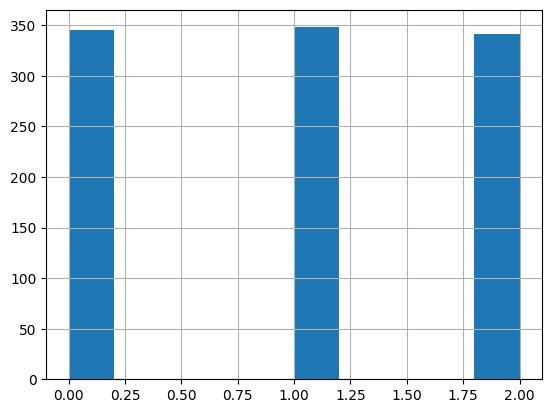

In [ ]:
df_train.labels.hist()

In [ ]:
df_test = pd.read_parquet("hf://datasets/AI-Lab-Makerere/beans/" + splits["test"])

# Preprocessing

In [ ]:
import io, os, numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt; import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix


def decode_gray(byte_data, size=(28,28)):
    img = Image.open(io.BytesIO(byte_data)).convert("L").resize(size)
    return np.asarray(img, dtype=np.float32) / 255.0

def prep_gray(df):
    X = np.stack([decode_gray(row["image"]["bytes"])       for _,row in df.iterrows()])[..., np.newaxis]
    y = df["labels"].values.astype("int32")
    return X, y

def decode_rgb(byte_data, size=(224,224)):
    img = Image.open(io.BytesIO(byte_data)).convert("RGB").resize(size)
    return np.asarray(img, dtype=np.float32)

def prep_rgb(df, preprocess_fn):
    X = np.stack([decode_rgb(row["image"]["bytes"])        for _,row in df.iterrows()])
    X = preprocess_fn(X)
    y = df["labels"].values.astype("int32")
    return X, y


Xtr_g, ytr = prep_gray(df_train)
Xval_g, yval= prep_gray(df_val)
Xte_g, yte  = prep_gray(df_test)


# Training Baseline

In [ ]:
inputs = keras.Input(shape=(28,28,1))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.Conv2D(128,3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(3, activation='softmax')(x)

baseline = keras.Model(inputs, outputs, name="baseline_28x28")
baseline.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n Training BASELINE …")
baseline.fit(Xtr_g, ytr, validation_data=(Xval_g,yval), epochs=5, batch_size=32)



 Training BASELINE …
Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.3980 - loss: 1.0988 - val_accuracy: 0.4962 - val_loss: 1.0331
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5567 - loss: 0.9379 - val_accuracy: 0.5639 - val_loss: 0.9862
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5923 - loss: 0.8854 - val_accuracy: 0.5639 - val_loss: 0.9691
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6325 - loss: 0.8174 - val_accuracy: 0.5639 - val_loss: 1.0497
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6572 - loss: 0.7625 - val_accuracy: 0.5414 - val_loss: 0.9199


## Pre-trained CNN - Model 1

In [ ]:

def make_tl_model(backbone, n_classes=3, trainable_fraction=0.2):
    backbone.trainable = False
    model = keras.Sequential([
        backbone,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    if trainable_fraction>0:
        n = len(backbone.layers)
        for layer in backbone.layers[int((1-trainable_fraction)*n):]:
            layer.trainable = True
    model.compile(optimizer=keras.optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def train_tl(model_name, builder, preprocess_fn):
    print(f"\n Training {model_name} …")
    Xtr_rgb, ytr_rgb   = prep_rgb(df_train, preprocess_fn)
    Xval_rgb, yval_rgb = prep_rgb(df_val,   preprocess_fn)
    Xte_rgb,  yte_rgb  = prep_rgb(df_test,  preprocess_fn)
    model = builder()
    model.fit(Xtr_rgb, ytr_rgb,
              validation_data=(Xval_rgb, yval_rgb),
              epochs=5, batch_size=32)
    return model, (Xte_rgb, yte_rgb)

#MODEL A – MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_pre

mobilenet_builder = lambda: make_tl_model(
    MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)),
    n_classes=3, trainable_fraction=0.3)

mobilenet, test_rgb_mn = train_tl("MobileNetV2", mobilenet_builder, mobilenet_pre)





 Training MobileNetV2 …
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 492ms/step - accuracy: 0.6011 - loss: 0.8581 - val_accuracy: 0.8496 - val_loss: 0.4104
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9519 - loss: 0.1533 - val_accuracy: 0.8195 - val_loss: 0.4293
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9894 - loss: 0.0636 - val_accuracy: 0.8271 - val_loss: 0.4284
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9996 - loss: 0.0189 - val_accuracy: 0.8496 - val_loss: 0.4181
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 1.0000 - loss: 0.0141 - val_accuracy: 0.8797 - val_loss: 0.3617


# Pretrained Model 2

In [ ]:
#MODEL B – ResNet50

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pre

resnet_builder = lambda: make_tl_model(
    ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3)),
    n_classes=3, trainable_fraction=0.2)

resnet, test_rgb_rs = train_tl("ResNet50", resnet_builder, resnet_pre)


 Training ResNet50 …
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 598ms/step - accuracy: 0.6981 - loss: 0.7023 - val_accuracy: 0.9248 - val_loss: 0.2066
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.9828 - loss: 0.0663 - val_accuracy: 0.9248 - val_loss: 0.1780
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9953 - loss: 0.0207 - val_accuracy: 0.9323 - val_loss: 0.1588
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.9248 - val_loss: 0.1479
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.9398 - val_loss: 0.1371


# Eval metrics


══════════ Baseline 28×28 ══════════
                   precision    recall  f1-score   support

angular_leaf_spot       0.57      0.63      0.60        43
        bean_rust       0.64      0.42      0.51        43
          healthy       0.64      0.81      0.72        42

         accuracy                           0.62       128
        macro avg       0.62      0.62      0.61       128
     weighted avg       0.62      0.62      0.61       128



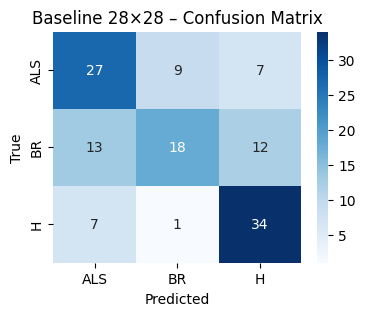

In [ ]:
def evaluate_and_report(model, X_test, y_test, name):
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    print(f"\n══════════ {name} ══════════")
    print(classification_report(y_test, y_pred, target_names=['angular_leaf_spot','bean_rust','healthy']))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['ALS','BR','H'], yticklabels=['ALS','BR','H'])
    plt.title(f"{name} – Confusion Matrix"); plt.ylabel("True"); plt.xlabel("Predicted")
    plt.show()

evaluate_and_report(baseline, Xte_g, yte, "Baseline 28×28")


══════════ MobileNetV2 224×224 ══════════
                   precision    recall  f1-score   support

angular_leaf_spot       0.97      0.84      0.90        43
        bean_rust       0.86      0.74      0.80        43
          healthy       0.78      1.00      0.88        42

         accuracy                           0.86       128
        macro avg       0.87      0.86      0.86       128
     weighted avg       0.87      0.86      0.86       128



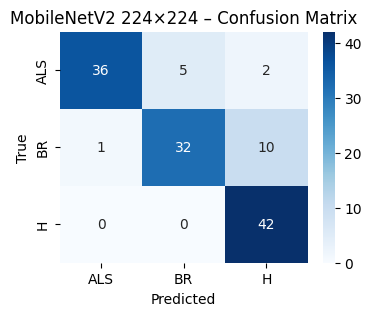

In [ ]:
evaluate_and_report(mobilenet, *test_rgb_mn, "MobileNetV2 224×224")



══════════ ResNet50 224×224 ══════════
                   precision    recall  f1-score   support

angular_leaf_spot       0.95      0.95      0.95        43
        bean_rust       0.95      0.95      0.95        43
          healthy       1.00      1.00      1.00        42

         accuracy                           0.97       128
        macro avg       0.97      0.97      0.97       128
     weighted avg       0.97      0.97      0.97       128



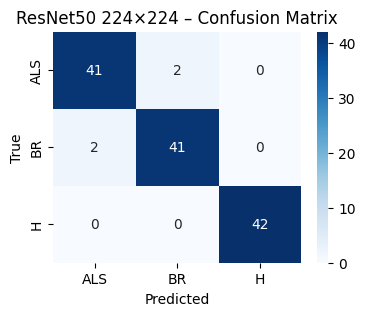

In [ ]:
evaluate_and_report(resnet,   *test_rgb_rs, "ResNet50 224×224")

# Saving to keras for Streamit

In [ ]:

from pathlib import Path, PurePath
import json, pickle

Path("saved_models").mkdir(exist_ok=True)

baseline.save("saved_models/baseline.keras")
mobilenet.save("saved_models/mobilenetv2.keras")
resnet.save("saved_models/resnet50.keras")

class_names = ['angular_leaf_spot', 'bean_rust', 'healthy']
with open("saved_models/classes.json", "w") as f:
    json.dump(class_names, f)

def dump_report(name, y_true, y_pred):
    rep = classification_report(y_true, y_pred, output_dict=True)
    with open(f"saved_models/{name}_report.json", "w") as f:
        json.dump(rep, f, indent=2)

y_pred_baseline = np.argmax(baseline.predict(Xte_g), axis=1)
dump_report("baseline",   yte, y_pred_baseline)

y_pred_mn = np.argmax(mobilenet.predict(test_rgb_mn[0]), axis=1)
dump_report("mobilenetv2",yte, y_pred_mn)

y_pred_rs = np.argmax(resnet.predict(test_rgb_rs[0]),  axis=1)
dump_report("resnet50",   yte, y_pred_rs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
